In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
from tqdm import tqdm_notebook
import warnings
from sklearn.preprocessing import LabelEncoder
import gc
import os
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import roc_auc_score

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv('train.csv')
label = pd.read_csv('train_label.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submission.csv')

# 数据探索

In [3]:
df_source = train.merge(label,on='ID',how='left')

# labelencoder

In [4]:
test['label'] = -1

In [5]:
train = train.merge(label,on='ID',how='left')
data = pd.concat([train, test])

In [6]:
num_round = 1000

In [7]:
cate_feature = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','E2','E3','E5','E7','E9','E10','E13','E16','E17','E19','E21','E22']
for item in cate_feature:
    data[item] = LabelEncoder().fit_transform(data[item])

In [8]:
train = data[data['label'] != -1]
test = data[data['label'] == -1]

# 特征工程

In [9]:
def get_base_fe(df):
    df['day'] = df.date.apply(lambda x:int(x[8:10]))
    df['time'] = pd.to_datetime(df['date'])
    timedelta = df['time'] - pd.datetime(df['time'].dt.year[0],df['time'].dt.month[0],df['time'].dt.day[0],0,0,0)

    df['hour'] = df.date.apply(lambda x:int(x[11:13]))
    df['ten_min'] = timedelta.dt.seconds/600
    df['ten_min'] = df['ten_min'].astype(int)
    del df['time']
    return df

In [10]:
def get_more_fe(df):
    uniq_list = ['C1','E14','A2','E1','E27']
    for i in uniq_list:
        tmp = df.groupby(['hour'])[i].nunique().reset_index(name = i+'_h_uniq')
        df  = df.merge(tmp, on=['hour'], how='left')
        tmp1 = df.groupby(['date'])[i].nunique().reset_index(name = i+'_d_uniq')
        df  = df.merge(tmp1, on=['date'], how='left')
    dev_list = ['D1','D2']
    for i in dev_list:
        tmp = df.groupby(['C1'])[i].nunique().reset_index(name = i+'_C1_de_uniq')
        df  = df.merge(tmp, on=['C1'], how='left')
        tmp1 = df.groupby(['C2'])[i].nunique().reset_index(name = i+'_C2_de_uniq')
        df  = df.merge(tmp1, on=['C2'], how='left')
        tmp2 = df.groupby(['C3'])[i].nunique().reset_index(name = i+'_C3_de_uniq')
        df  = df.merge(tmp2, on=['C3'], how='left')
    return df

In [11]:
train_df = get_base_fe(train)
test_df = get_base_fe(test)

In [12]:
# train_df = get_more_fe(train_df)
# test_df = get_more_fe(test_df)

In [13]:
test_df.shape

(40000, 46)

In [14]:
train_df.shape

(60000, 46)

# 删除不需要的字段

In [15]:
## get train feature
del_feature = ['ID','day','date','label','D2']
features = [i for i in train_df.columns if i not in del_feature]

In [16]:
train_x = train_df[features]
train_y = train_df['label'].values
test = test_df[features]

# 训练参数的选取

In [17]:
params = {'num_leaves': 60,
          'min_data_in_leaf': 30,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,
          # 'lambda_l2': 0.001,
          "verbosity": -1,
          "nthread": -1,
          'metric': {'binary_logloss', 'auc'},
          "random_state": 2019,
          # 'device': 'gpu'
          }

# 五折交叉

In [27]:
folds = KFold(n_splits=5, shuffle=True, random_state=2048)
prob_oof = np.zeros((train_x.shape[0], ))
test_pred_prob = np.zeros((test.shape[0], ))

In [28]:
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])


    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=200,
                    categorical_feature=cate_feature,
                    early_stopping_rounds=60)
    prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold 1
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.386628	training's auc: 0.787057	valid_1's binary_logloss: 0.413078	valid_1's auc: 0.722999
fold 2
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.387442	training's auc: 0.784328	valid_1's binary_logloss: 0.41068	valid_1's auc: 0.738138
fold 3
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.382975	training's auc: 0.792658	valid_1's binary_logloss: 0.403717	valid_1's auc: 0.726723
fold 4
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.382545	training's auc: 0.791774	valid_1's binary_logloss: 0.415692	valid_1's auc: 0.719348
fold 5
Training until validation scores don't improve for 60 rounds.
Early stoppi

# roc评估

In [36]:
score=roc_auc_score(train_y,prob_oof)
score

0.7240938836971511

In [30]:
sub['label'] = test_pred_prob

In [31]:
sub.loc[sub.label<=0.15,'label'] = 0
sub.loc[sub.label>0.15,'label'] = 1

In [32]:
label.label.value_counts()

0    49756
1    10244
Name: label, dtype: int64

In [33]:
sub.label.value_counts()

1.0    20314
0.0    19686
Name: label, dtype: int64

In [39]:
sub.to_csv('C:/Users/DELL/Desktop/sub/'+str(socore%.2f)+'.csv',encoding='utf-8',index=False)

SyntaxError: invalid syntax (<ipython-input-39-84d0b6e25819>, line 1)

# feature_importance展示

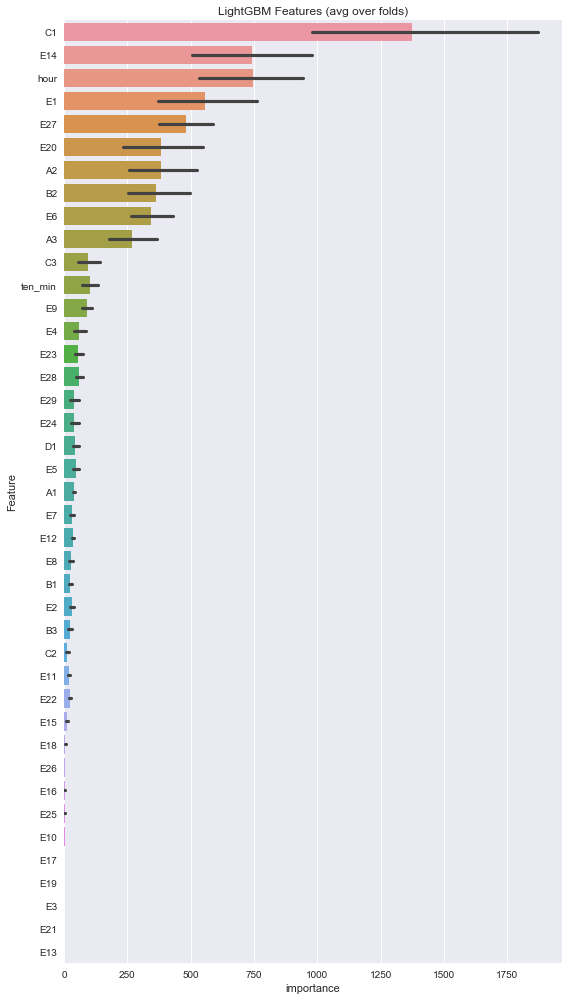

In [26]:
## plot feature importance
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)].sort_values(by='importance',ascending=False)
plt.figure(figsize=(8, 14))
sns.barplot(y="Feature",
            x="importance",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()